In [398]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [399]:
data=pd.read_csv( "data/data_model.csv", sep=",")

- On veut modéliser la hauteur moyenne des vagues hautes 1h à l'avance donc à T+1 pour St Nazaré
- On va enlever les données non nécessaires du data set les lag allant de 2 à 23 (pour éviter que ça soit redondant)
- Ajouter lag 1 pour la variable hauteur moyenne des vagues hautes pour les autres balises
- Pour avoir la variable cible il faut shifter cette dernière

In [400]:
data.head()

,Temps moyen entre les vagues,Direction moyenne des vagues,Période des vagues énergétiques,Hauteur moyenne des vagues les plus hautes,temps_moyen_entre_les_vagues_2016_2017_1129,direction_moyene_des_vagues_2016_2017_1129,temps_moyen_entre_les_vagues_energetiques_2016_2017_1129,hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_1129,temps_moyen_entre_les_vagues_2016_2017_1118,direction_moyene_des_vagues_2016_2017_1118,...,Hauteur moyenne des vagues les plus hautes_lag_22,Hauteur moyenne des vagues les plus hautes_lag_23,Hauteur moyenne des vagues les plus hautes_rolling_mean_24h,Hauteur moyenne des vagues les plus hautes_rolling_std_24h,hour,hour_sin,hour_cos,Hauteur moyenne des vagues les plus hautes_target,month,season
0,10.277721,0.334779,14.730517,3.490737,10.861396,0.424323,14.690897,4.170059,10.749910,0.426009,...,2.614599,2.581360,3.089948,0.292237,23,-0.258819,0.965926,2.515582,1,0
1,10.254212,0.335589,14.743447,3.501528,10.844849,0.426131,14.710769,4.184670,10.738215,0.427954,...,2.654079,2.614599,3.128288,0.282821,0,0.000000,1.000000,2.463134,1,0
2,10.228110,0.336257,14.753474,3.509845,10.825637,0.427837,14.728780,4.196269,10.723679,0.429793,...,2.702538,2.654079,3.165590,0.270911,1,0.258819,0.965926,2.413333,1,0
3,10.199312,0.336771,14.760477,3.515597,10.803640,0.429431,14.744819,4.204734,10.706166,0.431511,...,2.760034,2.702538,3.201486,0.256902,2,0.500000,0.866025,2.366782,1,0
4,10.168637,0.337242,14.765240,3.519368,10.779817,0.431023,14.759665,4.210864,10.686752,0.433232,...,2.817256,2.760034,3.235521,0.241577,3,0.707107,0.707107,2.321984,1,0


In [401]:
# Supprimer les lag allant de 3 à 23 pour Hauteur moyenne des vagues les plus hautes
cols_lag_drop = [f"Hauteur moyenne des vagues les plus hautes_lag_{i}" for i in range(3, 24)]
data = data.drop(columns=cols_lag_drop)

In [402]:
# Lag pour St Nazaré
columns_to_lag = ['Direction moyenne des vagues', 'Temps moyen entre les vagues']
lags = [1, 2, 3]

for column in columns_to_lag:
    for lag in lags:
        data[f'{column}_lag_{lag}'] = data[column].shift(lag)

In [403]:
# Temps moyen entre les vagues avec un lag de 1
data['Période des vagues énergétiques_lag_1'] = data['Période des vagues énergétiques'].shift(1)

In [404]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Temps moyen entre les vagues,17497.0,6.976560,1.949652,3.007394,5.336574,6.744879e+00,8.336771,12.794645
Direction moyenne des vagues,17497.0,0.383601,0.325958,-0.962609,0.242460,4.592439e-01,0.616361,0.940346
Période des vagues énergétiques,17497.0,11.096219,2.155595,4.502103,9.387197,1.114274e+01,12.766678,17.357317
Hauteur moyenne des vagues les plus hautes,17497.0,1.312141,0.656746,0.326232,0.881588,1.125568e+00,1.582914,4.445147
temps_moyen_entre_les_vagues_2016_2017_1129,17497.0,7.218073,1.944023,3.298572,5.577109,6.981496e+00,8.607282,13.137815
direction_moyene_des_vagues_2016_2017_1129,17497.0,0.452985,0.314452,-0.948593,0.333773,5.282766e-01,0.674270,0.993520
temps_moyen_entre_les_vagues_energetiques_2016_2017_1129,17497.0,11.153017,2.142648,4.646813,9.495382,1.122081e+01,12.786056,17.253552
hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_1129,17497.0,1.574763,0.757092,0.396054,1.067302,1.370914e+00,1.899515,5.366242
temps_moyen_entre_les_vagues_2016_2017_1118,17497.0,7.123342,1.903717,3.154718,5.536334,6.874739e+00,8.471741,13.005015
direction_moyene_des_vagues_2016_2017_1118,17497.0,0.465018,0.330890,-0.984702,0.338696,5.471984e-01,0.700632,1.011016


In [405]:
# Liste des colonnes sur lesquelles appliquer le rolling window
columns_to_lag = [
    'temps_moyen_entre_les_vagues_2016_2017_1129',
    'direction_moyene_des_vagues_2016_2017_1129',
    'temps_moyen_entre_les_vagues_energetiques_2016_2017_1129',
    'hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_1129',
    'temps_moyen_entre_les_vagues_2016_2017_1118',
    'direction_moyene_des_vagues_2016_2017_1118',
    'temps_moyen_entre_les_vagues_energetiques_2016_2017_1118',
    'hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_1118',
    'temps_moyen_entre_les_vagues_2016_2017_1119',
    'direction_moyene_des_vagues_2016_2017_1119',
    'temps_moyen_entre_les_vagues_energetiques_2016_2017_1119',
    'hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_1119'
]

# Appliquer le rolling mean avec une fenêtre de taille 3 (t, t-1, t-2)
for column in columns_to_lag:
    data[f'{column}_rolling_mean_t_to_minus_2'] = data[column].rolling(window=3).mean()


In [406]:
# Création de la cible (T+1)
data['target'] = data['Hauteur moyenne des vagues les plus hautes'].shift(-1)
# En raison du shift, il n'y aura pas de T+1 pour la dernière observation (on l'a supprime donc)
data = data.dropna(subset=['target'])

In [407]:
print(data[['Hauteur moyenne des vagues les plus hautes', 'target']].head(10))
# pour voir si le décalage ets bon et me semble que oui

   Hauteur moyenne des vagues les plus hautes    target
0                                    3.490737  3.501528
1                                    3.501528  3.509845
2                                    3.509845  3.515597
3                                    3.515597  3.519368
4                                    3.519368  3.521430
5                                    3.521430  3.515879
6                                    3.515879  3.501259
7                                    3.501259  3.481247
8                                    3.481247  3.455081
9                                    3.455081  3.417871


In [408]:
# Création d'une variable binaire pour les mois où les vagues sont hautes octobre à avril
data['périodes_hautes'] = data['month'].apply(lambda x: 1 if x in [10,11,12,1,2,3,4] else 0)

In [409]:
data = data.drop(columns=['Hauteur moyenne des vagues les plus hautes_target'])

In [410]:
# 3 dernières heure t à t-2 window rolling
data['Hauteur_moyenne_vagues_rolling_mean_t_to_minus_2'] = data['Hauteur moyenne des vagues les plus hautes'].rolling(window=3).mean()

In [411]:
# Supprimer les lignes contenant des valeurs manquantes car avec les lag etc il y a des NaN et il faut allignement
data = data.dropna()

- La transforlation cos/sin de l'heure permet d'éviter que le modèle pense que 23h et 0 sont très éloignés 
- rolling_mean_24h : Capture la tendance générale des vagues sur les 24 dernières heures.
- rolling_std_24h : Capture la variabilité des vagues sur cette période (haute si les vagues sont irrégulières, basse si elles sont stables).

==> à discuter si l'on garde ou non


In [412]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Temps moyen entre les vagues,17493.0,6.975805e+00,1.949236,3.007394,5.336303,6.743827e+00,8.335800,12.794645
Direction moyenne des vagues,17493.0,3.836042e-01,0.325994,-0.962609,0.242409,4.592951e-01,0.616456,0.940346
Période des vagues énergétiques,17493.0,1.109539e+01,2.155144,4.502103,9.386760,1.114243e+01,12.765364,17.357317
Hauteur moyenne des vagues les plus hautes,17493.0,1.311717e+00,0.656163,0.326232,0.881526,1.125520e+00,1.582824,4.445147
temps_moyen_entre_les_vagues_2016_2017_1129,17493.0,7.217241e+00,1.943467,3.298572,5.576914,6.981066e+00,8.606368,13.137815
direction_moyene_des_vagues_2016_2017_1129,17493.0,4.529849e-01,0.314487,-0.948593,0.333762,5.283198e-01,0.674281,0.993520
temps_moyen_entre_les_vagues_energetiques_2016_2017_1129,17493.0,1.115221e+01,2.142223,4.646813,9.495199,1.122055e+01,12.785595,17.253552
hauteur_moyenne_du_tier_des_vagues_les_plus_hautes_2016_2017_1129,17493.0,1.574254e+00,0.756362,0.396054,1.067270,1.370676e+00,1.898922,5.366242
temps_moyen_entre_les_vagues_2016_2017_1118,17493.0,7.122518e+00,1.903154,3.154718,5.536043,6.874262e+00,8.471097,13.005015
direction_moyene_des_vagues_2016_2017_1118,17493.0,4.650207e-01,0.330927,-0.984702,0.338468,5.472708e-01,0.700713,1.011016


### Modélisation

### J'ai enlevé hour month et season

In [413]:
# Trier les données par index temporel 
series_data = data.sort_index()

# Séparer les features et la target 
features = series_data.drop(columns=["target","hour","month","season","Hauteur moyenne des vagues les plus hautes_rolling_mean_24h", "Hauteur moyenne des vagues les plus hautes_rolling_std_24h"])
target = series_data["target"]

# Taille totale des données
total_size = len(series_data)

# Proportions pour train, validation, et test
train_ratio = 0.7  # 70 % pour l'entraînement
val_ratio = 0.15   # 15 % pour la validation
test_ratio = 0.15  # 15 % pour le test

# Calcul des indices pour découpage
train_end = int(total_size * train_ratio)
val_end = int(total_size * (train_ratio + val_ratio))

# Découpage en ensembles temporels
X_train, y_train = features.iloc[:train_end], target.iloc[:train_end]
X_val, y_val = features.iloc[train_end:val_end], target.iloc[train_end:val_end]
X_test, y_test = features.iloc[val_end:], target.iloc[val_end:]

# Vérification des splits
print(f"Train: {len(X_train)} observations")
print(f"Validation: {len(X_val)} observations")
print(f"Test: {len(X_test)} observations")

# Vérification des indices pour s'assurer du bon découpage temporel
print("Train index range:", X_train.index.min(), "-", X_train.index.max())
print("Validation index range:", X_val.index.min(), "-", X_val.index.max())
print("Test index range:", X_test.index.min(), "-", X_test.index.max())

Train: 12245 observations
Validation: 2624 observations
Test: 2624 observations
Train index range: 3 - 12247
Validation index range: 12248 - 14871
Test index range: 14872 - 17495


In [414]:
# Initialisation du modèle XGBoost
model = xgb.XGBRegressor(
    objective="reg:squarederror",  
    n_estimators=200,
    learning_rate=0.01,
    max_depth=5,                            
    random_state=42
)

# Entraînement uniquement sur le jeu de train, avec validation utilisée pour suivre les performances
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],  # Juste pour l'évaluation, pas pour l'entraînement
    verbose=1,
)

# Prédictions sur le jeu de validation
y_val_pred = model.predict(X_val)
# Prédictions sur le jeu de test
y_test_pred = model.predict(X_test)

# Calcul des métriques pour le jeu de validation
mae_val = mean_absolute_error(y_val, y_val_pred)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Calcul des métriques pour le jeu de test
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Affichage des résultats
print(f"MAE sur le jeu de validation: {mae_val:.4f}")
print(f"RMSE sur le jeu de validation: {rmse_val:.4f}")
print(f"MAE sur le jeu de test: {mae_test:.4f}")
print(f"RMSE sur le jeu de test: {rmse_test:.4f}")


[0]	validation_0-rmse:0.51853


[1]	validation_0-rmse:0.51334
[2]	validation_0-rmse:0.50822
[3]	validation_0-rmse:0.50314
[4]	validation_0-rmse:0.49810
[5]	validation_0-rmse:0.49312
[6]	validation_0-rmse:0.48818
[7]	validation_0-rmse:0.48329
[8]	validation_0-rmse:0.47845
[9]	validation_0-rmse:0.47365
[10]	validation_0-rmse:0.46890
[11]	validation_0-rmse:0.46420
[12]	validation_0-rmse:0.45957
[13]	validation_0-rmse:0.45496
[14]	validation_0-rmse:0.45041
[15]	validation_0-rmse:0.44590
[16]	validation_0-rmse:0.44144
[17]	validation_0-rmse:0.43704
[18]	validation_0-rmse:0.43267
[19]	validation_0-rmse:0.42836
[20]	validation_0-rmse:0.42407
[21]	validation_0-rmse:0.41984
[22]	validation_0-rmse:0.41564
[23]	validation_0-rmse:0.41150
[24]	validation_0-rmse:0.40738
[25]	validation_0-rmse:0.40331
[26]	validation_0-rmse:0.39927
[27]	validation_0-rmse:0.39529
[28]	validation_0-rmse:0.39136
[29]	validation_0-rmse:0.38747
[30]	validation_0-rmse:0.38359
[31]	validation_0-rmse:0.37976
[32]	validation_0-rmse:0.37599
[33]	validation_0

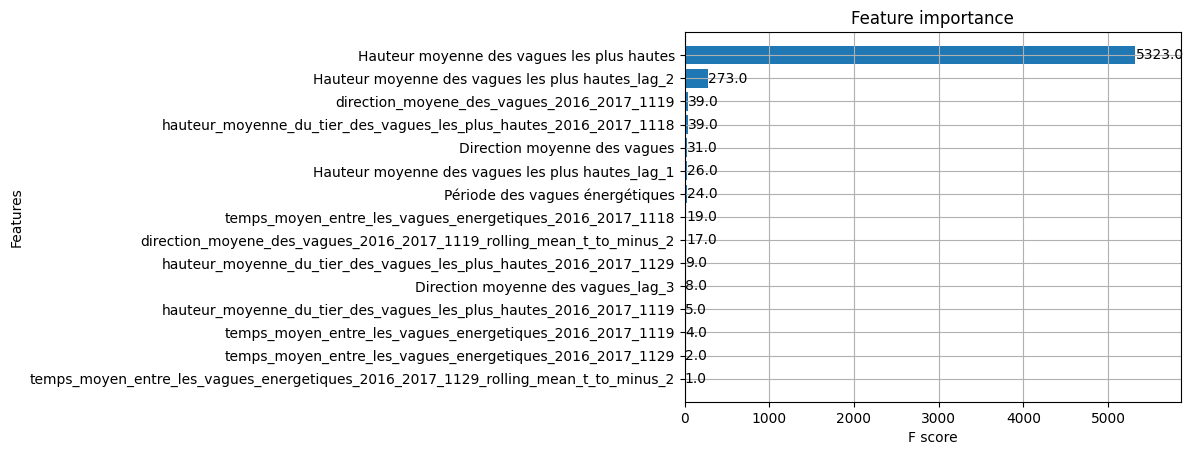

In [415]:
# Importance des variables
xgb.plot_importance(model, height=0.8, max_num_features=15)
plt.show()

### Ajout du Benchmark

📌 Benchmark 4h: MAE = 0.9995, RMSE = 1.0934
📌 XGBoost: MAE = 0.0757, RMSE = 0.0940


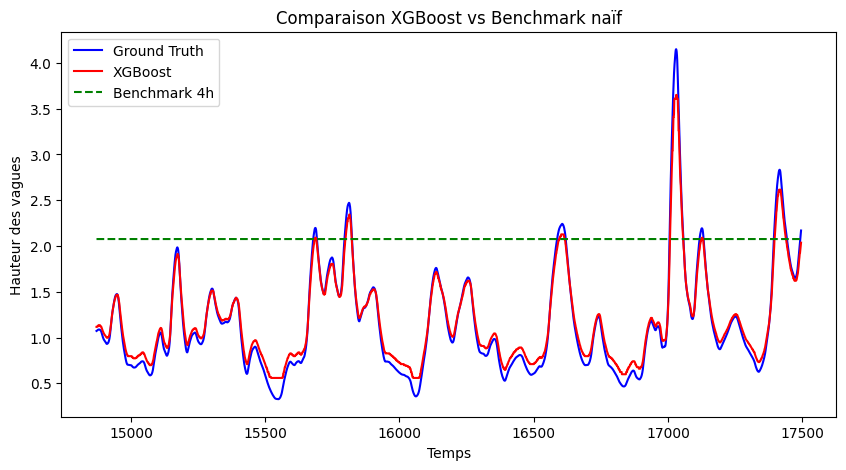

In [416]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 📌 Benchmark basé sur la moyenne des 3 dernières heures
def benchmark_4h(series_data, X_test):
    # Calcul de la moyenne des 4 dernières valeurs de la variable cible
    forecast = np.mean(series_data['Hauteur_moyenne_vagues_rolling_mean_t_to_minus_2'][-3:])
    
    # Générer des prédictions constantes égales à cette moyenne
    y_pred_mean = np.ones(len(X_test)) * forecast

    return y_pred_mean

# 📌 Exécuter le benchmark
y_pred_mean = benchmark_4h(series_data, X_test)

# 📌 Évaluer la performance du benchmark
mae_mean = mean_absolute_error(y_test, y_pred_mean)
rmse_mean = np.sqrt(mean_squared_error(y_test, y_pred_mean))

print(f"📌 Benchmark 4h: MAE = {mae_mean:.4f}, RMSE = {rmse_mean:.4f}")

# 📌 Comparer avec le modèle XGBoost
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"📌 XGBoost: MAE = {mae_test:.4f}, RMSE = {rmse_test:.4f}")

# 📌 Tracer les résultats
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label='Ground Truth', color='blue')
plt.plot(y_test.index, y_test_pred, label='XGBoost', color='red')
plt.plot(y_test.index, y_pred_mean, label='Benchmark 4h', color='green', linestyle="dashed")

plt.xlabel('Temps')
plt.ylabel('Hauteur des vagues')
plt.title('Comparaison XGBoost vs Benchmark naïf')
plt.legend()
plt.show()


In [417]:
# Fonction pour évaluer le modèle XGBoost
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    # Entraînement du modèle
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],  # Utilisation du jeu de validation
        verbose=1
    )
    
    # Prédictions
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # Calcul des métriques pour le jeu de validation
    mae_val = mean_absolute_error(y_val, y_val_pred)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

    # Calcul des métriques pour le jeu de test
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    return mae_val, rmse_val, mae_test, rmse_test, y_test_pred

# Fonction pour le benchmarking basé sur la moyenne des 3 dernières heures avant predictions
def benchmark_4h(X_test, y_test):
    y_pred_mean = X_test['Hauteur_moyenne_vagues_rolling_mean_t_to_minus_2']

    mae_mean = mean_absolute_error(y_test, y_pred_mean)
    rmse_mean = np.sqrt(mean_squared_error(y_test, y_pred_mean))

    return mae_mean, rmse_mean, y_pred_mean

# Fonction pour afficher les résultats
def print_results(mae_xgb, rmse_xgb, mae_mean, rmse_mean):
    print(f"📌 XGBoost:      MAE = {mae_xgb:.4f}, RMSE = {rmse_xgb:.4f}")
    print(f"📌 Benchmark 3h:  MAE = {mae_mean:.4f}, RMSE = {rmse_mean:.4f}")

# Initialisation du modèle XGBoost
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=200,
    learning_rate=0.01,
    max_depth=5,
    random_state=42
)

# Évaluation du modèle XGBoost
mae_val, rmse_val, mae_test, rmse_test, y_test_pred = evaluate_model(
    xgb_model, X_train, y_train, X_val, y_val, X_test, y_test
)

# Benchmarking de la prédiction 3h
mae_mean, rmse_mean, y_pred_mean = benchmark_4h(X_test, y_test)

# Affichage des résultats
print_results(mae_test, rmse_test, mae_mean, rmse_mean)

[0]	validation_0-rmse:0.51853
[1]	validation_0-rmse:0.51334
[2]	validation_0-rmse:0.50822
[3]	validation_0-rmse:0.50314
[4]	validation_0-rmse:0.49810
[5]	validation_0-rmse:0.49312
[6]	validation_0-rmse:0.48818
[7]	validation_0-rmse:0.48329
[8]	validation_0-rmse:0.47845
[9]	validation_0-rmse:0.47365
[10]	validation_0-rmse:0.46890
[11]	validation_0-rmse:0.46420
[12]	validation_0-rmse:0.45957
[13]	validation_0-rmse:0.45496
[14]	validation_0-rmse:0.45041
[15]	validation_0-rmse:0.44590
[16]	validation_0-rmse:0.44144
[17]	validation_0-rmse:0.43704
[18]	validation_0-rmse:0.43267
[19]	validation_0-rmse:0.42836
[20]	validation_0-rmse:0.42407
[21]	validation_0-rmse:0.41984
[22]	validation_0-rmse:0.41564
[23]	validation_0-rmse:0.41150
[24]	validation_0-rmse:0.40738
[25]	validation_0-rmse:0.40331
[26]	validation_0-rmse:0.39927
[27]	validation_0-rmse:0.39529
[28]	validation_0-rmse:0.39136
[29]	validation_0-rmse:0.38747
[30]	validation_0-rmse:0.38359
[31]	validation_0-rmse:0.37976
[32]	validation_0-

Size of y_test: 2624
Size of y_pred: 2624
Size of y_test: 2624
Size of y_pred after adjustment: 2624


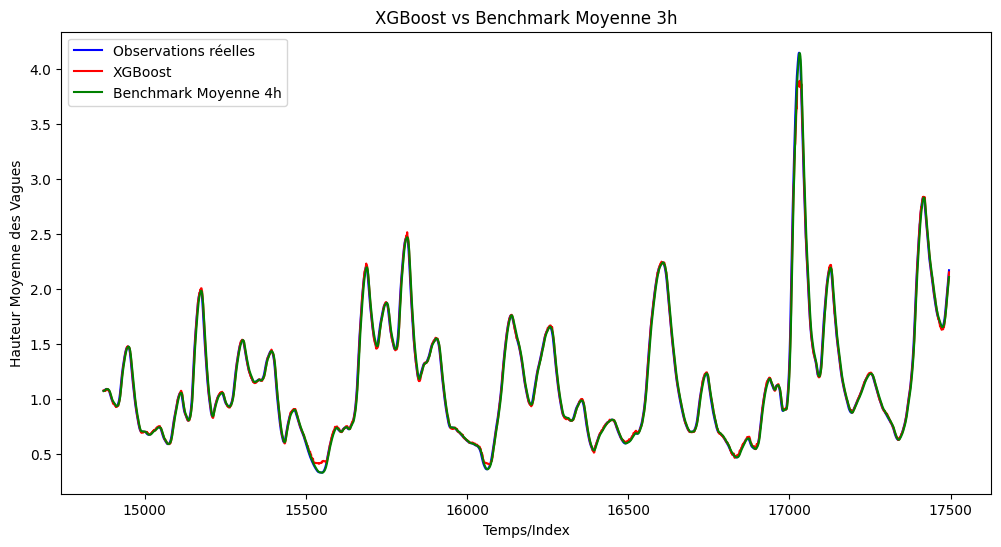

In [418]:
# Vérification des tailles
print(f"Size of y_test: {len(y_test)}")
print(f"Size of y_pred: {len(y_pred)}")
y_pred = y_pred[:len(y_test)]

# Vérification après la modification
print(f"Size of y_test: {len(y_test)}")
print(f"Size of y_pred after adjustment: {len(y_pred)}")

# Tracer les courbes
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Observations réelles", color='blue')
plt.plot(y_test.index, y_pred, label="XGBoost", color='red')
plt.plot(y_test.index, y_pred_mean, label="Benchmark Moyenne 4h", color='green')

# Ajout des labels et du titre
plt.xlabel("Temps/Index")
plt.ylabel("Hauteur Moyenne des Vagues")
plt.title("XGBoost vs Benchmark Moyenne 3h")

# Affichage de la légende et du graphique
plt.legend()
plt.show()

